___________________________________
- código final para a Análise Espectral de Holo hilbert usando o formato .SET
- baseado no tutorial: https://emd.readthedocs.io/en/stable/emd_tutorials/02_spectrum_analysis/emd_tutorial_02_spectrum_02_holospectrum.html

In [ ]:
!pip install emd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import matplotlib.pyplot as plt
from scipy.io import loadmat
import numpy as np
import emd
from scipy import ndimage

In [ ]:
def holospectrum(data):
    config = emd.sift.get_config('mask_sift')
    config['max_imfs'] = 4
    config['mask_freqs'] = 'if'
    config['mask_amp_mode'] = 'ratio_imf'
    config['imf_opts/sd_thresh'] = 0.5
    config['mask_step_factor'] = 5

    imf = emd.sift.mask_sift(data.T, **config)

    IP, IF, IA = emd.spectra.frequency_transform(imf, 256, 'nht')

    def mask_sift_second_layer(IA, masks, config={}):
        imf2 = np.zeros((IA.shape[0], IA.shape[1], config['max_imfs']))
        for ii in range(IA.shape[1]):
            config['mask_freqs'] = masks[ii:]
            tmp = emd.sift.mask_sift(IA[:, ii], **config)
            imf2[:, ii, :tmp.shape[1]] = tmp
        return imf2

    masks = np.array([25/2**ii for ii in range(12)])/256
    config = emd.sift.get_config('mask_sift')
    config['mask_amp_mode'] = 'ratio_imf'
    config['max_imfs'] = 4
    config['imf_opts/sd_thresh'] = 0.05
    config['envelope_opts/interp_method'] = 'pchip'

    imf2 = emd.sift.mask_sift_second_layer(IA, masks, sift_args=config)

    IP2, IF2, IA2 = emd.spectra.frequency_transform(imf2, 256, 'nht')

    carrier_hist = (1, 100, 128,'log')

#and one for the amplitude modulations
    am_hist = (1e-2, 100, 128, 'log')

#compute 1d HHT (power over carrier freq)
    fcarrier, spec = emd.spectra.hilberthuang(IF, IA, carrier_hist, sum_imfs=False)

    fcarrier, hht = emd.spectra.hilberthuang(IF, IA, carrier_hist, sum_time=False)
    shht = ndimage.gaussian_filter(hht, 2)

    fcarrier, fam, holo = emd.spectra.holospectrum(IF, IF2, IA2, carrier_hist, am_hist)
    sholo = ndimage.gaussian_filter(holo, 1)

    np.nan_to_num(sholo,copy=False)

    return fcarrier, fam, sholo, shht, spec

In [ ]:
path    = r'/content/drive/MyDrive/LABNEP/REGISTROS OFICIAL/mat/average_grupo_experimental.mat'
path_1  = r'/content/drive/MyDrive/LABNEP/REGISTROS OFICIAL/mat/average_grupo_controle.mat'

exp     = loadmat(path) ##abre arquivos .SET
control = loadmat(path_1)

'F7' - 0
'T3' - 1
'T5' - 2
'Fp1' - 3
'F3' - 4
'C3' - 5
'P3' - 6
'O1' - 7
'F8' - 8
'T4' - 9
'T6' - 10
'Fp2' - 11
'F4' - 12
'C4' - 13
'P4' - 14
'O2' - 15
'Fz' - 16
'Cz' - 17
'Pz' - 18
'Oz' - 19
'A1' - 20
'A2' - 21

In [ ]:
data_exp     = exp['averageMatrix'][16]
data_control = control['averageMatrix'][16]

<ipython-input-13-df0464c2169d>:6: UserWarning: The following kwargs were not used by contour: 'shade'
  cp = ax1.contourf(fcarrier_exp, fam_exp, (sholo_exp.T)**0.25, cmap = 'jet', shade = 'nearest', levels=np.linspace(np.min(sholo_exp.T)**0.25, np.max(sholo_exp.T)**0.25, 40))
<ipython-input-13-df0464c2169d>:7: UserWarning: The following kwargs were not used by contour: 'shade'
  cp = ax2.contourf(fcarrier_control, fam_control, (sholo_control.T)**0.25, cmap = 'jet', shade = 'nearest', levels=np.linspace(np.min(sholo_control.T)**0.25, np.max(sholo_control.T)**0.25, 40))


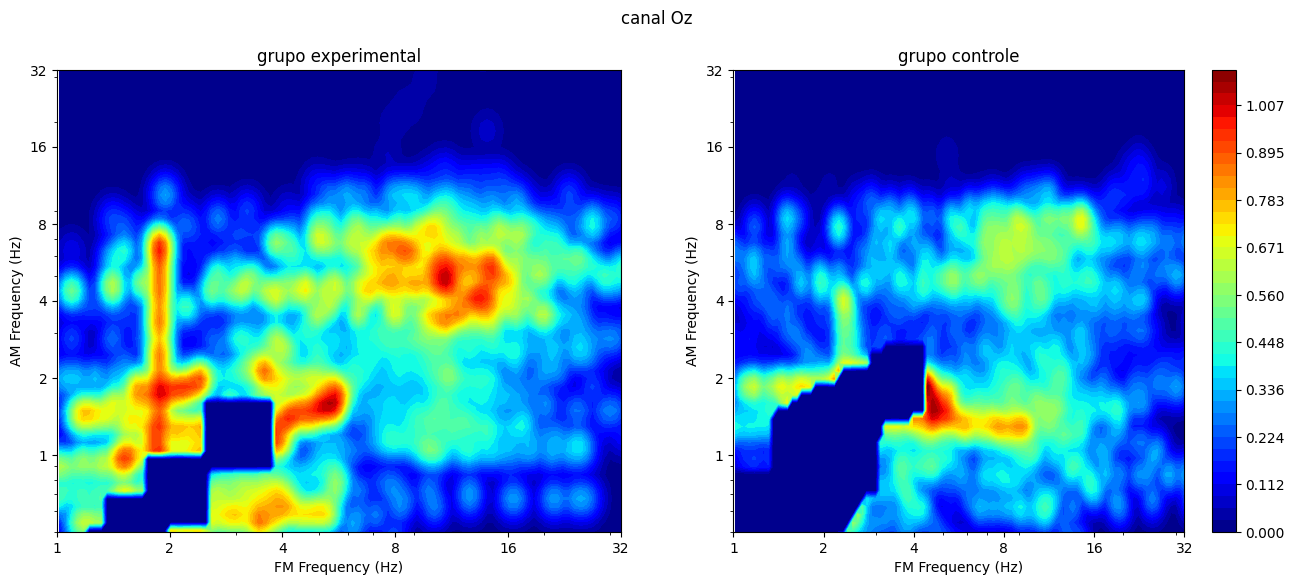

In [ ]:
fcarrier_exp, fam_exp, sholo_exp, shht_exp, spec_exp = holospectrum(data_exp)
fcarrier_control, fam_control, sholo_control, shht_control, spec_control = holospectrum(data_control)

fig,(ax1, ax2)=plt.subplots(1,2, figsize=(16,6))

cp = ax1.contourf(fcarrier_exp, fam_exp, sholo_exp.T, cmap = 'jet', shade = 'nearest', levels=np.linspace(np.min(sholo_exp.T), np.max(sholo_exp.T), 40))
cp = ax2.contourf(fcarrier_control, fam_control, sholo_control.T, cmap = 'jet', shade = 'nearest', levels=np.linspace(np.min(sholo_control.T), np.max(sholo_control.T), 40))

ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_ylim(0.5,32)
ax1.set_xlim(1,32)
ax1.set_yticks(2**np.arange(6),2**np.arange(6))
ax1.set_xticks(2**np.arange(6),2**np.arange(6))
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_ylim(0.5,32)
ax2.set_xlim(1,32)
ax2.set_yticks(2**np.arange(6),2**np.arange(6))
ax2.set_xticks(2**np.arange(6),2**np.arange(6))
plt.colorbar(cp)
#cb.set_label(r'$V^{2}$', rotation=0)

fig.suptitle('canal Oz')
ax1.set_title('grupo experimental')
ax1.set_xlabel('FM Frequency (Hz)')
ax1.set_ylabel('AM Frequency (Hz)')
ax2.set_title('grupo controle')
ax2.set_xlabel('FM Frequency (Hz)')
ax2.set_ylabel('AM Frequency (Hz)')
plt.savefig('canal Oz')
plt.show()

In [ ]:
seconds = 768
sample_rate = 256
t = np.linspace(0, seconds, seconds*sample_rate)

<function matplotlib.pyplot.show(close=None, block=None)>

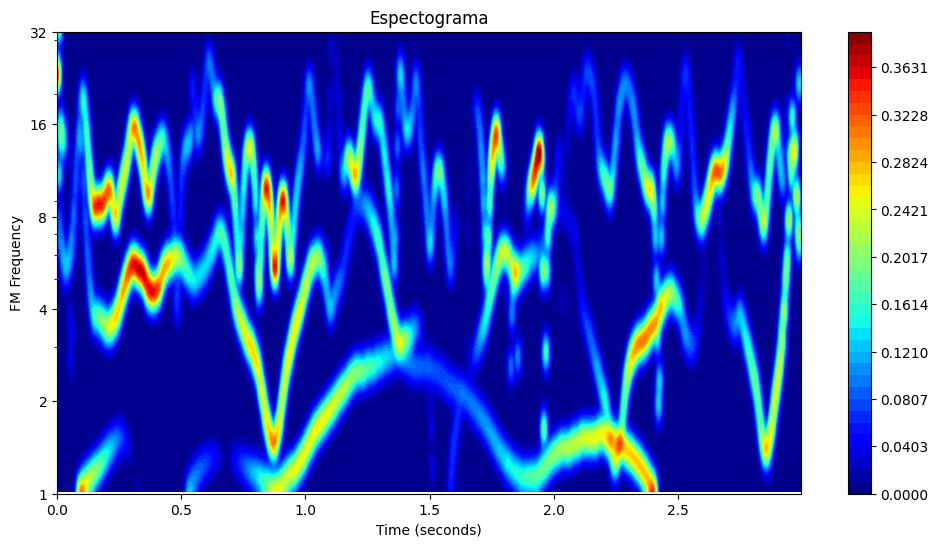

In [ ]:
fig,ax=plt.subplots(1,1, figsize=(12,6))
cb = ax.contourf(t[:sample_rate*3], fcarrier_control, shht_control=, cmap='jet',
                 levels=np.linspace(np.min(shht_control), np.max(shht_control)**0.5, 40))
#plt.pcolormesh((t[:sample_rate*120]), fcarrier, (shht[:, :sample_rate*120]), cmap='ocean_r')
plt.colorbar(cb)
plt.yscale('log')
plt.title('Espectograma')
plt.xlabel('Time (seconds)')
plt.ylabel('FM Frequency')
plt.ylim(2,32)
plt.yticks(2**np.arange(6), 2**np.arange(6))
plt.savefig('espectograma_t1_T3.png', format='png')
plt.show

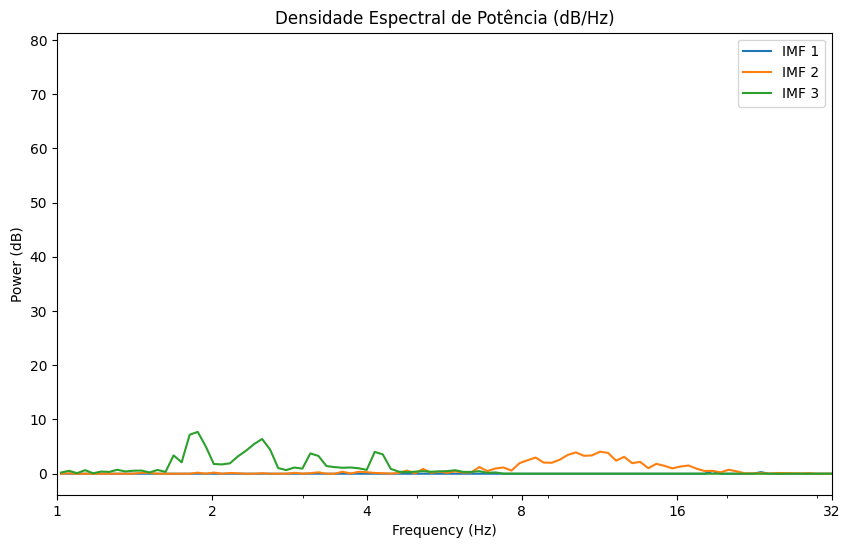

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(fcarrier, spec[:,:3], label =("IMF 1", 'IMF 2', 'IMF 3'))

plt.xscale('log')
plt.xticks(2**np.arange(6),2**np.arange(6))
plt.xlim(fcarrier[0], fcarrier[-1])
plt.xlim(1,32)

plt.title('Densidade Espectral de Potência (dB/Hz)')
plt.ylabel('Power (dB)')
plt.xlabel('Frequency (Hz)')

plt.legend()
plt.show()